In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sys
sys.path.append('model/')
from mlp import *
from tqdm import tqdm
import itertools
from utils import *
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from simple_agent import *
from buffer import *

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1234)

%load_ext autoreload
%autoreload 2
#plt.style.use('dark_background')
plt.style.use('seaborn-deep')

# Set parameters

In [3]:
# Model selection 
# Training script parameters can be found at: https://wandb.ai/aipp/Laser-Agents/table
pt_agent_name = 'data_fix_512_1_20000000_2fvoqkyp_misunderstood-cloud-199'
pt_surrogate_name = 'data_fix_512_1_1000000_2kr0nb76_still-gorge-225'

surrogate_num_hidden = 1
agent_num_hidden = 1
surrogate_act = torch.tanh

# Optimization learning rates
agent_lr = 1e-6
surrogate_lr = 1e-5

# Used training parameters
pwl_train=True
val_train=True
norm_power=False

# Data preprocessing
smooth_states = True
norm_states = True

# Normalization as agent feature
norm_feature = False
clip_norm = False
minmax_norm=False

# Activation function in last layer
last_layer_act_agent=True
last_layer_act_surrogate=True

# Plotting data
x_vals_setting = np.load('setting_x_values.npy')
x_vals_spectrum = np.load('spectrum_x_values.npy')

# Surrogate

## Data loading phase

In [4]:
states, actions = get_data(smooth_states=smooth_states, norm_states = norm_states, norm_power=norm_power)
start_states = states[:,:int(states.shape[1]/2)]
next_states = states[:,int(states.shape[1]/2):]
surrogate_states = torch.cat([start_states, actions], dim=1)
surrogate_actions = next_states
if pwl_train:
    base_actions = actions.clone()
    actions, xn, xp = get_pwl_actions(actions.float().to(device)) 
    surrogate_states, xn, xp = get_pwl_surrogate_states(surrogate_states)

include_bad_examples = False

if include_bad_examples:
    bad_waves = create_bad_examples(actions[:,1:].numpy())
    bad_settings = torch.tensor(np.concatenate((np.random.uniform(0,0.5,size=(bad_waves.shape[0],1)),bad_waves), axis=1))
    bad_surrogate_actions = -1* torch.ones(bad_settings.shape)
    bad_surrogate_states = torch.cat([start_state[np.random.randint(0,surrogate_states.shape[0],size=bad_settings.shape[0])], bad_settings], dim=1)

    surrogate_states = torch.cat([surrogate_states, bad_surrogate_states],dim=0)
    surrogate_actions = torch.cat([surrogate_actions, bad_surrogate_actions],dim=0)

val_loader = None
if val_train:
    np.random.seed(1234)
    val_size = 5 
    val_idx = np.random.choice(np.arange(46),val_size, replace=False)
    train_idx = np.setxor1d(np.arange(surrogate_states.shape[0]), val_idx)
    train_dataset = torch.utils.data.TensorDataset(surrogate_states[train_idx].float().to(device), surrogate_actions[train_idx].float().to(device))
    val_dataset = torch.utils.data.TensorDataset(surrogate_states[val_idx].float().to(device), surrogate_actions[val_idx].float().to(device))
    
else:
    train_dataset = torch.utils.data.TensorDataset(surrogate_states.float().to(device), surrogate_actions.float().to(device))

## Model loading

In [5]:
# surrogate testing:
surrogate = SimpleAgent(input_size=surrogate_states[0].shape[0], target_size=surrogate_actions[0].shape[0], hidden_size=512, num_hidden=surrogate_num_hidden, activation = surrogate_act, lr=surrogate_lr, last_layer_activation = last_layer_act_surrogate)
surrogate.agent.load_state_dict(torch.load('historic_data/surrogates/'+ pt_surrogate_name, map_location=device))

states, actions = val_dataset[:]

prediced_next_states = surrogate.agent(states.float().to(device))
loss = torch.nn.MSELoss(reduction='none')(actions.float().to(device), prediced_next_states).mean(dim=1).cpu().detach().numpy()
loss_sort_idx = loss.argsort()

## Inference validation data

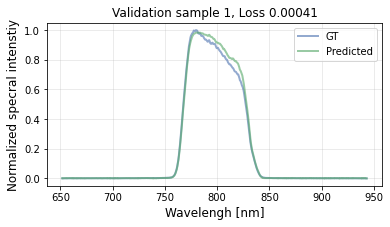

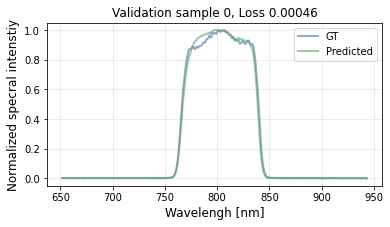

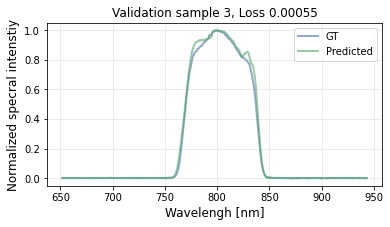

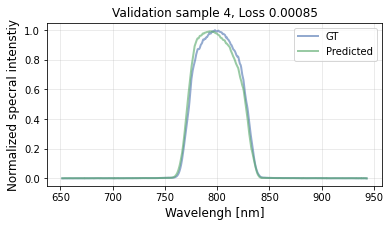

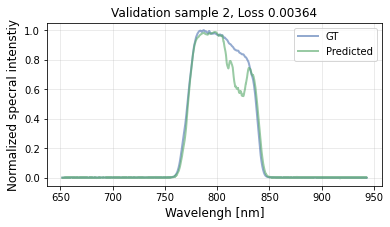

In [6]:
alpha=0.6
lw=2
for i in loss_sort_idx:
    predicted_next_state = surrogate.agent(states[i].float().to(device))
    plt.figure(figsize=(6,3))
    plt.plot(x_vals_spectrum, actions[i].cpu().detach().numpy(), label='GT', alpha=alpha, lw=lw)
    plt.plot(x_vals_spectrum, predicted_next_state.cpu().detach().numpy(), label='Predicted', alpha=alpha, lw=lw)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.ylabel("Normalized specral intenstiy", size=12)
    plt.xlabel("Wavelengh [nm]", size=12)
    plt.title("Validation sample {}, Loss {:.5f}".format(i, loss[i]))
    #plt.savefig("thesis_plots/val_spec_{}_spline".format(i), dpi=300)
    plt.show()

# Agent

## Data loading phase

In [7]:
train_with_live_data = True
train_with_hole_data = False
downsampling_rate = None

states, actions = get_data(smooth_states=smooth_states, norm_states = norm_states, norm_power=norm_power)
start_states = states[:,:int(states.shape[1]/2)]
next_states = states[:,int(states.shape[1]/2):]
surrogate_states = torch.cat([start_states, actions], dim=1)
surrogate_actions = next_states
#if pwl_train:
if False:
    base_actions = actions.clone()
    actions, xn, xp = get_pwl_actions(actions.float().to(device)) 
    surrogate_states, xn, xp = get_pwl_surrogate_states(surrogate_states)
    
val_loader = None
if val_train:
    np.random.seed(1234)
    val_size = 5 
    val_idx = np.random.choice(np.arange(46),val_size, replace=False)
    train_idx = np.setxor1d(np.arange(states.shape[0]), val_idx)
    train_dataset = torch.utils.data.TensorDataset(states[train_idx].float().to(device), actions[train_idx].float().to(device))
    val_dataset = torch.utils.data.TensorDataset(states[val_idx].float().to(device), actions[val_idx].float().to(device))
else:
    train_dataset = torch.utils.data.TensorDataset(states.float().to(device), actions.float().to(device))

## Model loading

In [8]:
# Agent testing:
pwl_train=pwl_train
agent = SimpleAgent(input_size=states[0].shape[0], target_size=43 if pwl_train else 2048, hidden_size=512, num_hidden=agent_num_hidden, activation = torch.sigmoid, lr=agent_lr, last_layer_activation = last_layer_act_agent, norm = norm_feature,  clip_norm = clip_norm, minmax_norm=minmax_norm, xn=xn if pwl_train else None, xp=xp if pwl_train else None)
agent.agent.load_state_dict(torch.load('historic_data/models/'+ pt_agent_name, map_location=device))

states, actions = val_dataset[:]

agent.agent.pwl = pwl_train
prediced_actions = agent.agent(states.float().to(device))
loss = torch.nn.MSELoss(reduction='none')(actions.float().to(device), prediced_actions).mean(dim=1).cpu().detach().numpy()
loss_sort_idx = loss.argsort()

## Inference validation data

Loss: 2.5367178750457242e-05
Loss: 5.113112190591185e-12


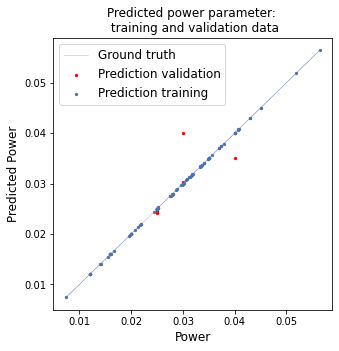

In [9]:
states, actions = val_dataset[:]

agent.agent.pwl = pwl_train
prediced_actions = agent.agent(states.float().to(device))

val_power = actions[:,0].cpu().detach().numpy()
val_predicted_power = prediced_actions[:,0].cpu().detach().numpy()
print("Loss: {}".format(torch.nn.MSELoss()(actions[:,0], prediced_actions[:,0])))
states, actions = train_dataset[:170]

agent.agent.pwl = pwl_train
prediced_actions = agent.agent(states.float().to(device))

train_power = actions[:,0].cpu().detach().numpy()
train_predicted_power = prediced_actions[:,0].cpu().detach().numpy()
print("Loss: {}".format(torch.nn.MSELoss()(actions[:,0], prediced_actions[:,0])))

plt.figure(figsize=(5,5))
s=5
#plt.scatter(power,power,label='GT',s=s)
plt.plot(train_power,train_power,alpha=0.5,lw=0.5, label="Ground truth")
plt.scatter(val_power, val_predicted_power, label='Prediction validation',s=s, c='red')
plt.scatter(train_power, train_predicted_power, label='Prediction training',s=s)

plt.xlabel("Power", size=12)
plt.ylabel("Predicted Power", size=12)
plt.legend(fontsize=12)
plt.title("Predicted power parameter: \n training and validation data")
#plt.savefig("thesis_plots/power_val_spline",dpi=300)
plt.show()

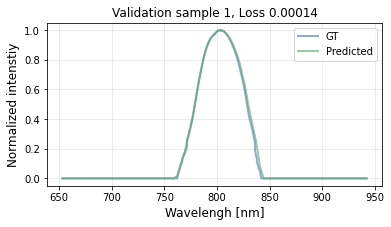

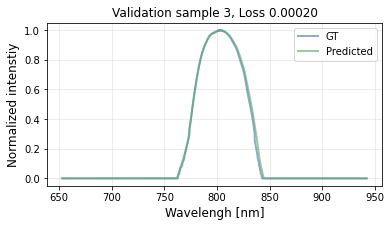

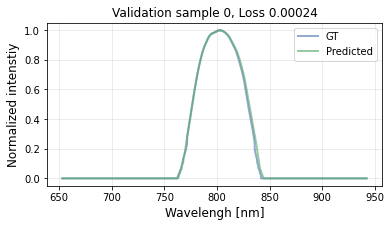

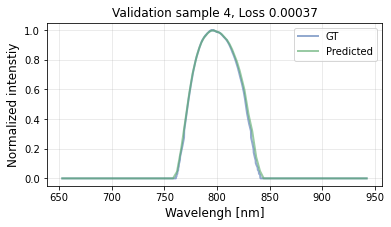

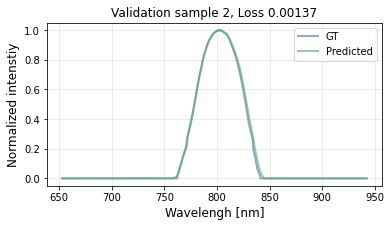

In [10]:
alpha=0.6
lw=2

for i in loss_sort_idx:
    predicted_action = agent.agent(states[i].float().to(device).unsqueeze(0))[0]
    plt.figure(figsize=(6,3))
    plt.plot(x_vals_setting, actions[i][1:].cpu().detach().numpy(), label='GT', alpha=alpha, lw=lw)
    plt.plot(x_vals_setting, predicted_action[1:].cpu().detach().numpy(), label='Predicted', alpha=alpha, lw=lw)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.ylabel("Normalized intenstiy", size=12)
    plt.xlabel("Wavelengh [nm]", size=12)
    plt.title("Validation sample {}, Loss {:.5f}".format(i, loss[i]))
    plt.show()